# Doc2Vec
We take snippets from 1497 books and **train a doc2vec model** on them.

Next, we explore **most similar documents** to 2 selected documents. Do these documents come from the same author? Do they have same genre?

In the following, we project the document vectors to 2D using **PCA** and **t-SNE** and plot them. Are documents written by the same author close to each other? Can we observe clusters based on genres?


In [1]:
import gensim # sudo pip3 install gensim
from gensim.models.doc2vec import Doc2Vec
import os
import collections
import numpy as np 
import random
import pickle
import multiprocessing
import pandas as pd
import zipfile

cores = multiprocessing.cpu_count()

RES = '../res/'
SAMPLE_BOOKS_CLEAN_FOLDER = '../res/books_clean' # 1497 books with Gutenberg header and footer stripped
TOKENIZED_DOCS_FOLDER = '../res/tokenized_docs'

SAMPLE_BOOKS_CLEAN_URL = "http://www.ms.mff.cuni.cz/~bilekja/books_sample_clean.zip"
BOOKS_ZIP_FILENAME = '../res/books_sample_clean.zip'

In [2]:
LOAD_DATASET = True
TOKENIZE = True

Download 1497 books from Project Gutenberg. The texts are already preprocessed and headers and footers relating to Project Gutenberg are removed.

In [3]:
if LOAD_DATASET:
    !curl "http://www.ms.mff.cuni.cz/~bilekja/books_sample_clean.zip" -o $BOOKS_ZIP_FILENAME
    z = zipfile.ZipFile(BOOKS_ZIP_FILENAME)
    z.extractall(RES)

In [4]:
def tokenize_corpus(folder):
    total_books = len(os.listdir(folder))
    i=0
    for filename in os.listdir(folder):
        i+=1
        print("\r{} out of {} books processed".format(i,total_books),end='')
        with open(os.path.join(folder,filename), encoding="utf-8") as f:
            doc_id = filename.split('.')[0]
            book_text = f.read()
            # tokenized the book text
            tokens = gensim.utils.simple_preprocess(book_text)
            pickle.dump(tokens, open(os.path.join(TOKENIZED_DOCS_FOLDER, doc_id), 'wb'))

!mkdir -p $TOKENIZED_DOCS_FOLDER
if TOKENIZE:
    tokenize_corpus(SAMPLE_BOOKS_CLEAN_FOLDER)

Get `$WORDS_IN_DOCUMENT` words from the beginning of the book. We skip first `$FILTER_FIRST_N_WORDS` words as it may still contain book title, author name, content or other noise.

In [5]:
SKIP_FIRST_N_WORDS = 500
WORDS_IN_DOCUMENT = 2000

Load the Tagged Documents and pickle the whole corpus (might cause problem for big files).

In [6]:
def load_corpus(folder, skip_first_n_words = None, words_in_document = None):
    for doc_id in os.listdir(folder):
        tokens = pickle.load(open(os.path.join(folder, doc_id),'rb'))
        tokens = tokens[ skip_first_n_words: skip_first_n_words + words_in_document ]
        yield gensim.models.doc2vec.TaggedDocument(tokens, [doc_id])

documents = list(load_corpus(TOKENIZED_DOCS_FOLDER, skip_first_n_words=SKIP_FIRST_N_WORDS, words_in_document=WORDS_IN_DOCUMENT))
pickle.dump(documents, open('../res/documents_{}_{}.pkl'.format(SKIP_FIRST_N_WORDS, WORDS_IN_DOCUMENT), 'wb'))

Populate the vocabulary of the doc2vec model.

In [7]:
#train_corpus = pickle.load(open('../res/corpus_500_words.pkl','rb'))

#model = Doc2Vec(vector_size=50, min_count=2, epochs=55, workers=-1)
#model = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=5, negative=5, hs=0, min_count=2, workers=cores)
#model = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, workers=cores)
model = Doc2Vec(dm=1, dm_mean=1, vector_size=100, window=10, negative=5, hs=0, min_count=2, workers=cores)
model.build_vocab(documents)
model.save('../res/model_{}_words'.format(WORDS_IN_DOCUMENT))

Train the model (might take long time for big corpora).

In [8]:
%time model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
model.save('../res/model_{}_words'.format(WORDS_IN_DOCUMENT))

CPU times: user 27.7 s, sys: 228 ms, total: 27.9 s
Wall time: 9.48 s


As the documents are 0 indexed in Doc2Vec, we create a lookup table to keep track of document ids.

In [9]:
lookup_table = dict()
for n, (tokens, key) in enumerate(documents):
    lookup_table[key[0]] = n
    
book_ids = list(lookup_table.keys())

Representation of document vectors.

In [10]:
docvecs = np.array([model.docvecs[book_id] for book_id in book_ids])

### Fetch metadata catalog

In [11]:
METADATA_CATALOG_URL = 'http://www.ms.mff.cuni.cz/~bilekja/metadata_catalog.pkl.zip'
METADATA_CATALOG_ZIP_PATH = '../res/metadata_catalog.pkl.zip'
METADATA_CATALOG_PATH = '../res/metadata_catalog.pkl'

In [12]:
if not os.path.exists(METADATA_CATALOG_PATH):
    # load the metadata catalog
    !curl $METADATA_CATALOG_URL -o $METADATA_CATALOG_ZIP_PATH
    # unzip it
    z2 = zipfile.ZipFile(METADATA_CATALOG_ZIP_PATH)
    z2.extractall(RES)

# unpickle it - the format is dictionary
metadata_catalog_dict = pickle.load(open(METADATA_CATALOG_PATH,'rb'))
# convert the catalog to pandas DataFrame for more convenient handling
metadata_catalog = pd.DataFrame.from_dict(metadata_catalog_dict, orient='index').set_index('id')
# keep only books we have in our corpus
metadata_catalog = metadata_catalog[metadata_catalog.index.isin(book_ids)]
metadata_catalog.head()

,author,title,downloads,formats,type,LCC,subjects,authoryearofbirth,authoryearofdeath,language
id,,,,,,,,,,
13,"Carroll, Lewis",The Hunting of the Snark: An Agony in Eight Fits,304.0,{'application/rdf+xml': 'http://www.gutenberg....,Text,{PR},"{Nonsense verses, English}",1832.0,1898.0,[en]
15,"Melville, Herman",Moby Dick,856.0,{'text/plain; charset=us-ascii': 'http://www.g...,Text,{PS},"{Whaling ships -- Fiction, Adventure stories, ...",1819.0,1891.0,[en]
19,"Longfellow, Henry Wadsworth",The Song of Hiawatha,241.0,{'text/html; charset=us-ascii': 'http://www.gu...,Text,{PS},"{Hiawatha, active 15th century -- Poetry, Iroq...",1807.0,1882.0,[en]
20,"Milton, John",Paradise Lost,2252.0,{'application/x-mobipocket-ebook': 'http://www...,Text,{PR},{Bible. Genesis -- History of Biblical events ...,1608.0,1674.0,[en]
22,"Roget, Peter Mark",Roget's Thesaurus,328.0,{'application/x-mobipocket-ebook': 'http://www...,Text,{PE},{English language -- Synonyms and antonyms},1779.0,1869.0,[en]


Display most common authors along with number of books in the corpus.

In [13]:
author_counts = collections.Counter(metadata_catalog.author)
author_counts.most_common(10)

[('Shakespeare, William', 156),
 ('Balzac, Honoré de', 92),
 ('Harte, Bret', 48),
 ('Galsworthy, John', 32),
 (None, 31),
 ('Davis, Richard Harding', 28),
 ('Haggard, H. Rider (Henry Rider)', 26),
 ('London, Jack', 24),
 ('Doyle, Arthur Conan', 23),
 ('James, Henry', 22)]

Select 8 most common authors (excluding the author None).

In [14]:
most_common_authors = [author for author, count in author_counts.most_common(9)
                           if author != None]

Initialize variable authors that contains the author's name if the author is one of the most_common_authors. Put 'Other' otherwise.

In [15]:
authors = metadata_catalog.loc[[int(b) for b in book_ids]].author
authors.where(authors.isin(most_common_authors), 'Other', inplace=True)

Initialize variable genres. Book is assigned a genre if it covers exactly one of the genres of interest.

In [16]:
selected_genres = ['Fiction',
          'Short stories',
          'Detective and mystery stories',
          'Historical fiction',
          'Love stories',
          'Western stories',
          'Adventure Stories']

genres = metadata_catalog.subjects.apply(
    lambda x: list(x.intersection(selected_genres))[0] if len(x.intersection(selected_genres))==1 else '')

# Most similar texts

In [17]:
metadata_simple = metadata_catalog[['author','title','subjects']]
pd.set_option('display.max_colwidth', -1)

### The Adventures of Sherlock Holmes

In [18]:
doc_id = '1661'
n = 20

In [19]:
sims = np.array(model.docvecs.most_similar([model.docvecs[doc_id]], topn=n))

result = metadata_simple.copy().loc[[int(i) for i in sims[:n, 0]]]
result['score'] = sims[:n, 1]
result['score'] = result['score'].apply(lambda x: np.round(float(x),3))
result

,author,title,subjects,score
id,,,,
1661,"Doyle, Arthur Conan",The Adventures of Sherlock Holmes,"{Private investigators -- England -- Fiction, Holmes, Sherlock (Fictitious character) -- Fiction, Detective and mystery stories, English}",1.000
2852,"Doyle, Arthur Conan",The Hound of the Baskervilles,"{Blessing and cursing -- Fiction, Holmes, Sherlock (Fictitious character) -- Fiction, Dartmoor (England) -- Fiction, Detective and mystery stories, Private investigators -- England -- Fiction, Dogs -- Fiction}",0.849
2344,"Doyle, Arthur Conan",The Adventure of the Cardboard Box,"{Private investigators -- England -- Fiction, Detective and mystery stories, Holmes, Sherlock (Fictitious character) -- Fiction}",0.828
2841,"Haggard, H. Rider (Henry Rider)",The Ivory Child,"{Fantasy fiction, English, Adventure stories, Quatermain, Allan (Fictitious character) -- Fiction}",0.827
2867,"Harte, Bret",A Sappho of Green Springs,"{American fiction -- 19th century, California -- Social life and customs -- Fiction, Western stories}",0.818
2343,"Doyle, Arthur Conan",The Adventure of Wisteria Lodge,"{Private investigators -- England -- Fiction, Detective and mystery stories, Holmes, Sherlock (Fictitious character) -- Fiction}",0.811
2347,"Doyle, Arthur Conan",The Adventure of the Dying Detective,"{Private investigators -- England -- Fiction, Detective and mystery stories, Holmes, Sherlock (Fictitious character) -- Fiction}",0.810
2097,"Doyle, Arthur Conan",The Sign of the Four,"{Private investigators -- England -- Fiction, Detective and mystery stories, Holmes, Sherlock (Fictitious character) -- Fiction}",0.803
173,"Rohmer, Sax",The Insidious Dr. Fu Manchu,"{Detective and mystery stories, Criminals -- Fiction, Fu Manchu, Doctor (Fictitious character) -- Fiction}",0.799


### Pride and Prejudice

In [20]:
doc_id = '1342'
n = 20

In [21]:
sims = np.array(model.docvecs.most_similar([model.docvecs[doc_id]], topn=n))

result = metadata_simple.copy().loc[[int(i) for i in sims[:n, 0]]]
result['score'] = sims[:n, 1]
result['score'] = result['score'].apply(lambda x: np.round(float(x),3))
result

,author,title,subjects,score
id,,,,
1342,"Austen, Jane",Pride and Prejudice,"{Social classes -- Fiction, Sisters -- Fiction, Love stories, Courtship -- Fiction, Domestic fiction, Young women -- Fiction, England -- Fiction}",1.000
158,"Austen, Jane",Emma,"{Humorous stories, Fathers and daughters -- Fiction, Love stories, Young women -- Fiction, Female friendship -- Fiction, Mate selection -- Fiction, Bildungsromans, England -- Fiction}",0.856
1387,"Wister, Owen",Mother,"{Storytelling -- Fiction, Investments -- Fiction}",0.848
2155,"Moore, Frank Frankfort",Phyllis of Philistia,{Fiction},0.845
1586,"Collins, Wilkie",Man and Wife,"{Bigamy -- Fiction, England -- Fiction, Married women -- Fiction, Domestic fiction}",0.843
1808,"Davis, Richard Harding","The Log of the ""Jolly Polly""",{Man-woman relationships -- Fiction},0.835
1473,"Edgeworth, Maria",The Absentee,"{British -- Ireland -- Fiction, Socialites -- Fiction, Satire, Landowners -- Fiction, Domestic fiction, Ireland -- Fiction, Administration of estates -- Fiction, Absentee landlordism -- Fiction}",0.820
1839,"Wolf, Emma",Other Things Being Equal,"{Love stories, Interfaith marriage -- Fiction, Jewish families -- Fiction, Jews -- California -- San Francisco -- Fiction, Domestic fiction, Jewish fiction, Jewish women -- Fiction, San Francisco (Calif.) -- Fiction}",0.819
209,"James, Henry",The Turn of the Screw,"{Governesses -- Fiction, Psychological fiction, Ghost stories, Children -- Fiction, England -- Fiction}",0.818


# Visualization of docvecs in 2d using PCA and t-SNE

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

import itertools

markers = ['o','v','^','s','P','*','h','x','D']

## Authors

### PCA

In [23]:
from sklearn.decomposition.pca import PCA
pca = PCA(2)
docvecs_pca = pca.fit_transform(docvecs)

In [24]:
n = len(authors.unique())
author_colors = plt.cm.Set1(np.linspace(0, 1, n))
author_markers = itertools.cycle(markers)
author_color_marker_dict = {a : (author_colors[n], next(author_markers)) for n,a in enumerate(authors.unique())}

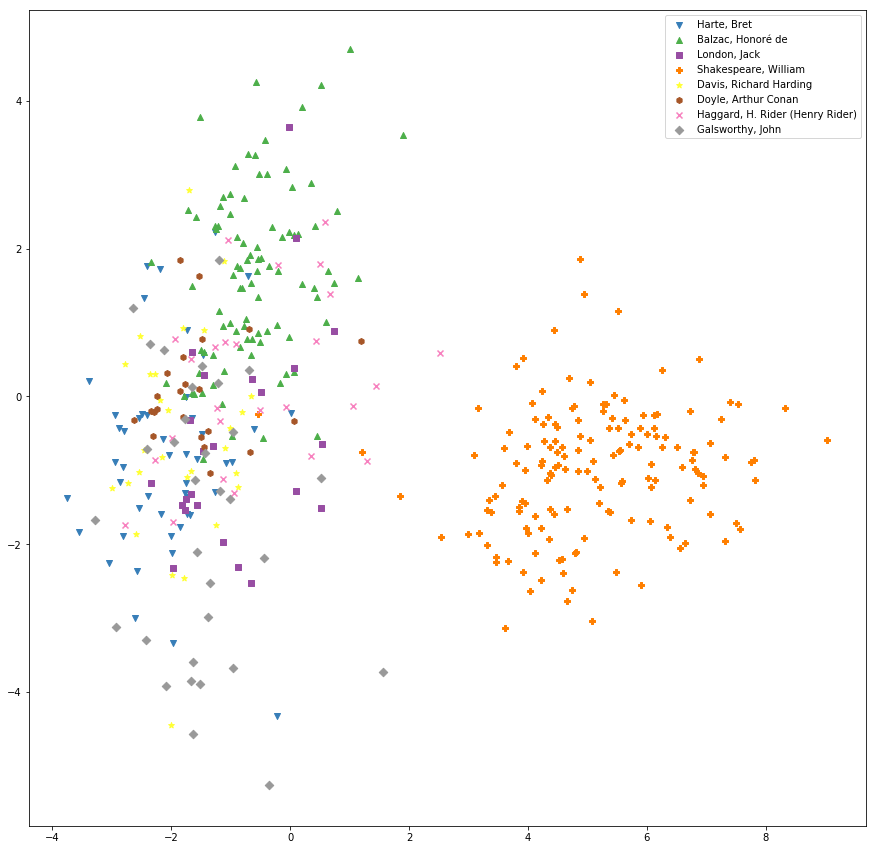

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for author,(color, marker) in author_color_marker_dict.items():
    x = docvecs_pca[authors == author, 0]
    y = docvecs_pca[authors == author, 1]
    if author == 'Other':
        continue
        alpha = 0.1
    else:
        alpha = 1
    ax.scatter(x, y, label=author, c=color, marker=marker, alpha=alpha)
    
ax.legend()

### TSNE

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
docvecs_tsne = tsne.fit_transform(docvecs)

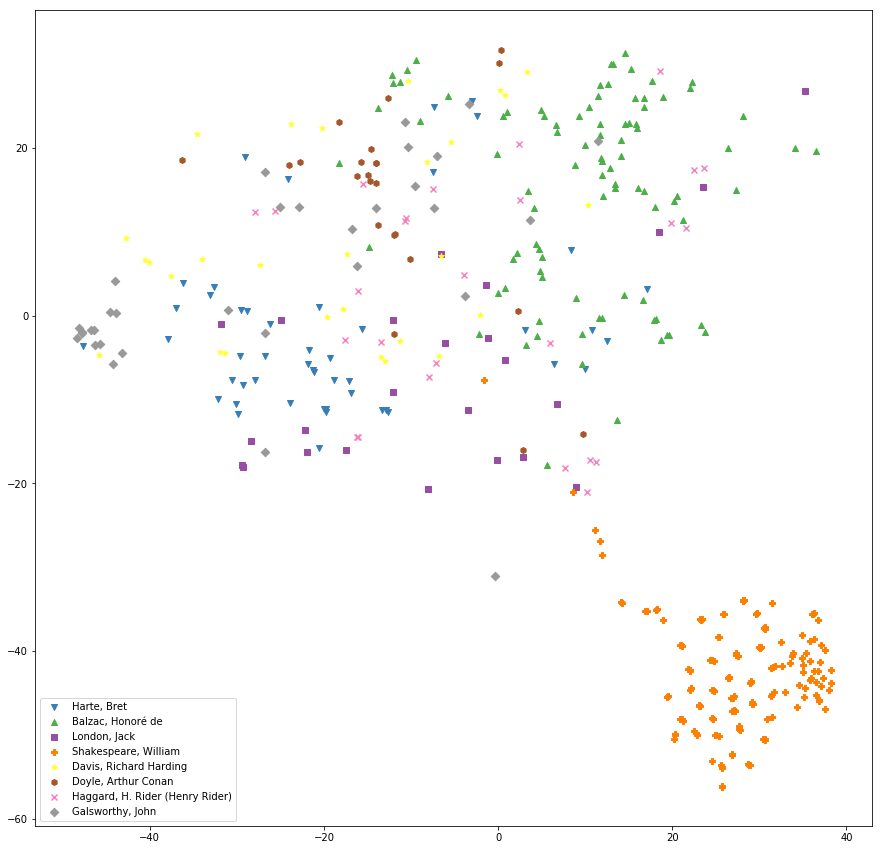

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for author,(color, marker) in author_color_marker_dict.items():
    x = docvecs_tsne[authors == author, 0]
    y = docvecs_tsne[authors == author, 1]
    if author == 'Other':
        continue
        alpha = 0.1
    else:
        alpha = 1
    ax.scatter(x, y, label=author, c=color, marker=marker, alpha=alpha)
    
ax.legend()

## Genres

### PCA

In [28]:
n = len(selected_genres)
genre_colors = plt.cm.Set1(np.linspace(0, 1, n))
genre_markers = itertools.cycle(markers)
print(genre_markers)
genre_color_marker_dict = {g : (genre_colors[n], next(genre_markers)) for n,g in enumerate(selected_genres)}

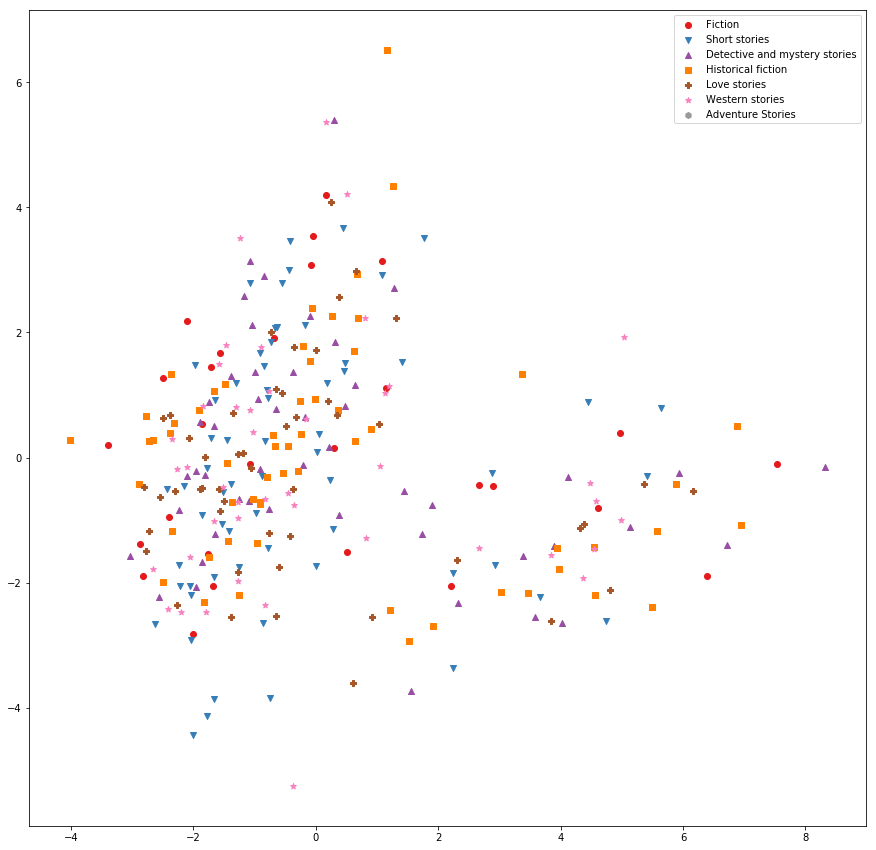

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for genre,(color, marker) in genre_color_marker_dict.items():
    x = docvecs_pca[genres == genre, 0]
    y = docvecs_pca[genres == genre, 1]
    alpha = 1
    ax.scatter(x, y, label=genre, c=color, marker=marker, alpha=alpha)
    
ax.legend()

### TSNE

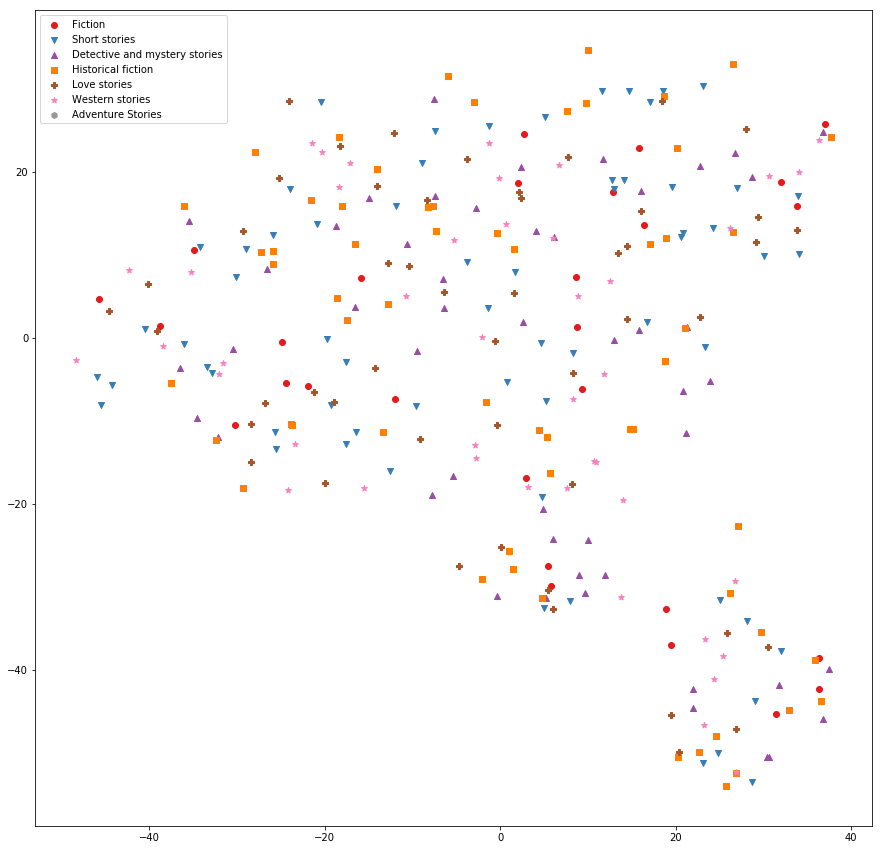

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for genre,(color, marker) in genre_color_marker_dict.items():
    x = docvecs_tsne[genres == genre, 0]
    y = docvecs_tsne[genres == genre, 1]
    alpha = 1
    ax.scatter(x, y, label=genre, c=color, marker=marker, alpha=alpha)
    
ax.legend()

# SUMMARY:
- The most similar documents are usually documents written by the same author or having similar genre.
- We can observe author clusters both using PCA and t-SNE dimensionality reduction
- For genres, on the other hand, clusters can't be clearly seen.

# NEXT:
- knn on genres
- redo experiment with tf-idf BOW (with and without ngrams) and compare results